In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
from datetime import datetime, timedelta

In [ ]:
start = datetime(2015, 1, 1)
end = datetime(2019, 1, 1)
# Fetch data using yfinance
df = yf.download('MSFT', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.305374,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,39.934742,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.348591,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,39.848534,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.020798,29645200
...,...,...,...,...,...,...
2018-12-24,97.680000,97.970001,93.980003,94.129997,89.059952,43935200
2018-12-26,95.139999,100.690002,93.959999,100.559998,95.143623,51634800
2018-12-27,99.300003,101.190002,96.400002,101.180000,95.730225,49498500


In [ ]:
#df = df['Close'].resample('W').mean()
#set index for pycaret modelling
#df.set_index('Date', inplace=True)
df = df['Close']
df = df.asfreq('D')
df = df.interpolate()
df2 = df.copy()
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1460 entries, 2015-01-02 to 2018-12-31
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [ ]:
df

,Close
Date,
2015-01-02,46.759998
2015-01-03,46.616666
2015-01-04,46.473334
2015-01-05,46.330002
2015-01-06,45.650002
...,...
2018-12-27,101.180000
2018-12-28,100.389999
2018-12-29,100.783333


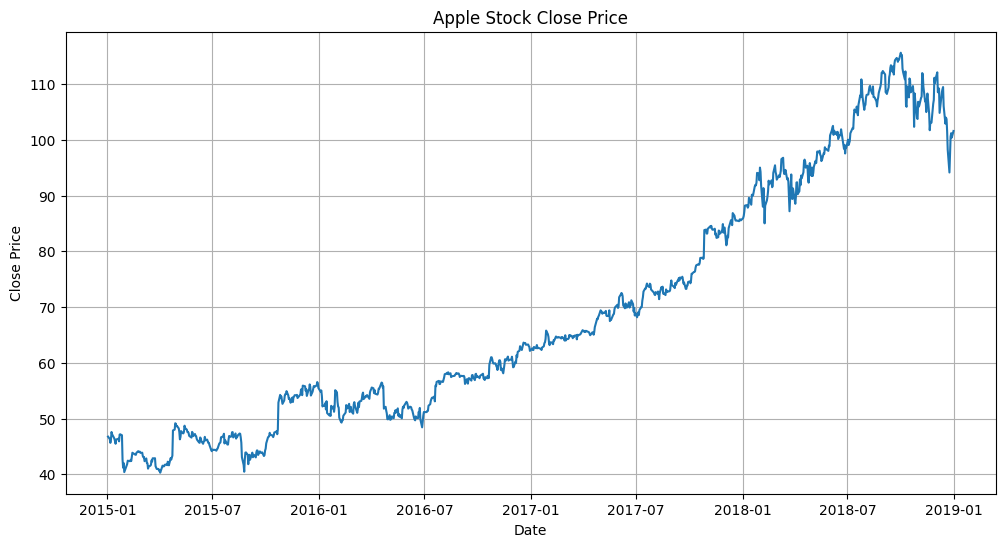

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import shapiro

def test_white_noise(series):
    # Ljung-Box test for white noise
    result = sm.stats.acorr_ljungbox(series, lags=[10], return_df=True)
    return result

def test_stationarity(series):
    # Use ADF and KPSS tests for stationarity
    adf_result = adfuller(series)
    kpss_result, p_value, lags, critical_values = kpss(series, regression='c')
    return adf_result, kpss_result

def test_adf(series):
    # Augmented Dickey-Fuller test
    result = adfuller(series)
    return result

def test_kpss(series):
    # Kwiatkowski-Phillips-Schmidt-Shin test
    result = kpss(series, regression='c')
    return result

def test_normality(series):
    # Shapiro-Wilk test for normality
    result = shapiro(series)
    return result

def run_all_tests(series):
    white_noise_result = test_white_noise(series)
    stationarity_adf_result, stationarity_kpss_result = test_stationarity(series)
    adf_result = test_adf(series)
    kpss_result = test_kpss(series)
    normality_result = test_normality(series)

    return {
        'White Noise Test': white_noise_result,
        'ADF Stationarity Test': adf_result,
        'KPSS Stationarity Test': kpss_result,
        'Normality Test': normality_result,
    }

def explain_results(results):
    explanations = {}

    # White Noise Test Explanation
    white_noise_result = results['White Noise Test']
    explanations['White Noise Test'] = (
        "Hypothesis: \n"
        "H0: The series is white noise.\n"
        "H1: The series is not white noise.\n"
        f"p-value: {white_noise_result['lb_pvalue'].iloc[0]}\n"
        f"Reject H0: {white_noise_result['lb_pvalue'].iloc[0] < 0.05}\n"
    )

    # ADF Stationarity Test Explanation
    adf_result = results['ADF Stationarity Test']
    explanations['ADF Stationarity Test'] = (
        "Hypothesis: \n"
        "H0: The series has a unit root (non-stationary).\n"
        "H1: The series is stationary.\n"
        f"ADF Statistic: {adf_result[0]}\n"
        f"p-value: {adf_result[1]}\n"
        f"Critical Values: {adf_result[4]}\n"
        f"Reject H0: {adf_result[1] < 0.05}\n"
    )

    # KPSS Stationarity Test Explanation
    kpss_result = results['KPSS Stationarity Test']
    explanations['KPSS Stationarity Test'] = (
        "Hypothesis: \n"
        "H0: The series is stationary.\n"
        "H1: The series is not stationary.\n"
        f"KPSS Statistic: {kpss_result[0]}\n"
        f"p-value: {kpss_result[1]}\n"
        f"Critical Values: {kpss_result[3]}\n"
        f"Reject H0: {kpss_result[1] < 0.05}\n"
    )

    # Normality Test Explanation
    normality_result = results['Normality Test']
    explanations['Normality Test'] = (
        "Hypothesis: \n"
        "H0: The data is normally distributed.\n"
        "H1: The data is not normally distributed.\n"
        f"Statistic: {normality_result[0]}\n"
        f"p-value: {normality_result[1]}\n"
        f"Reject H0: {normality_result[1] < 0.05}\n"
    )

    return explanations

results = run_all_tests(df)
explanations = explain_results(results)

print("White Noise Test Results:")
print(explanations['White Noise Test'])
print("\nADF Stationarity Test Results:")
print(explanations['ADF Stationarity Test'])
print("\nKPSS Stationarity Test Results:")
print(explanations['KPSS Stationarity Test'])
print("\nNormality Test Results:")
print(explanations['Normality Test'])

White Noise Test Results:
Hypothesis: 
H0: The series is white noise.
H1: The series is not white noise.
p-value: 0.0
Reject H0: True


ADF Stationarity Test Results:
Hypothesis: 
H0: The series has a unit root (non-stationary).
H1: The series is stationary.
ADF Statistic: 0.026431645992376115
p-value: 0.9606641391733595
Critical Values: {'1%': -3.4348772553489617, '5%': -2.8635394783531085, '10%': -2.5678345067434516}
Reject H0: False


KPSS Stationarity Test Results:
Hypothesis: 
H0: The series is stationary.
H1: The series is not stationary.
KPSS Statistic: 5.325951236074841
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0: True


Normality Test Results:
Hypothesis: 
H0: The data is normally distributed.
H1: The data is not normally distributed.
Statistic: 0.9032919406890869
p-value: 2.0159740905980768e-29
Reject H0: True



<ipython-input-7-50c345cd9e46>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result, p_value, lags, critical_values = kpss(series, regression='c')
<ipython-input-7-50c345cd9e46>:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


## pycaret

In [ ]:
#!pip install pycaret

In [ ]:
from pycaret.time_series import *
s = setup(df ,fh = 3, fold = 5, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1460, 1)"
5,Transformed data shape,"(1460, 1)"
6,Transformed train set shape,"(1457, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.3868,1.1085,2.9043,3.1120,0.0289,0.0285,-23.2138,0.2220
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.3957,1.1111,2.9198,3.1145,0.0291,0.0285,-18.2424,0.2540
naive,Naive Forecaster,1.3960,1.1064,2.9247,3.1077,0.0291,0.0287,-26.6698,2.2000
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.4044,1.1140,2.9405,3.1262,0.0294,0.0289,-18.2813,0.4120
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.4059,1.1151,2.9437,3.1296,0.0294,0.0289,-18.4560,0.2500
ets,ETS,1.4119,1.1219,2.9569,3.1495,0.0295,0.0290,-24.0372,0.5520
exp_smooth,Exponential Smoothing,1.4144,1.1256,2.9620,3.1598,0.0295,0.0291,-24.0769,0.3820
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.4187,1.1404,2.9676,3.1968,0.0295,0.0290,-19.0686,0.3500
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.4192,1.1408,2.9687,3.1979,0.0296,0.0290,-19.0942,0.3660
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.4245,1.1449,2.9800,3.2097,0.0297,0.0291,-19.3687,0.2240


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
print(best)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [17, 16,
                                                                        15, 14,
                                                                        13, 12,
                                                                        11, 10,
                                                                        9, 8, 7,
                                                                        6, 5, 4,
                                                                        3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=OrthogonalMatchingPursuit(), sp=17,
                    window_length=17)


In [ ]:
# functional API
plot_model(best, plot = 'diagnostics')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [ ]:
# functional API
plot_model(best, plot = 'insample')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [ ]:
# functional API
final_best = finalize_model(best)
predict_model(best, fh = 24)

,y_pred
2018-12-29,100.4205
2018-12-30,100.4337
2018-12-31,100.3990
2019-01-01,100.6888
2019-01-02,100.7065
2019-01-03,100.7064
2019-01-04,100.8039
2019-01-05,100.8380
2019-01-06,100.9427
2019-01-07,101.0785


In [ ]:
# functional API
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 360})

In [ ]:
save_model(final_best, 'final_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [17,
                                                                                                                                                                                                         16,
                                                                                                                                                                                                         15,
                       

In [ ]:
df2 = df2.reset_index()
df2.columns = ['ds', 'y']
df2

,ds,y
0,2015-01-02,46.759998
1,2015-01-03,46.616666
2,2015-01-04,46.473334
3,2015-01-05,46.330002
4,2015-01-06,45.650002
...,...,...
1455,2018-12-27,101.180000
1456,2018-12-28,100.389999
1457,2018-12-29,100.783333
1458,2018-12-30,101.176666


## prophet

In [ ]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly,plot_forecast_component_plotly,plot_seasonality_plotly, plot_components_plotly ,plot_cross_validation_metric
model = Prophet(interval_width = 0.95)
model.fit(df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqd2nbput/png6lxko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqd2nbput/y1s8enx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53230', 'data', 'file=/tmp/tmpqd2nbput/png6lxko.json', 'init=/tmp/tmpqd2nbput/y1s8enx1.json', 'output', 'file=/tmp/tmpqd2nbput/prophet_modelwi1ij__b/prophet_model-20240808125903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = model.make_future_dataframe(periods=360, freq='D')
future_dates.tail()

,ds
1815,2019-12-22
1816,2019-12-23
1817,2019-12-24
1818,2019-12-25
1819,2019-12-26


In [ ]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-02,45.397299,42.170616,48.786719
1,2015-01-03,45.341059,41.839954,48.471215
2,2015-01-04,45.300290,41.878126,48.507399
3,2015-01-05,45.272174,41.967091,48.748354
4,2015-01-06,45.280893,41.998752,48.686786


In [ ]:
fig = plot_plotly(model, forecast, uncertainty=True)
fig.update_layout(title_text='Microsoft Stock Price Forecast')
fig.show()

In [ ]:
fig2 = plot_components_plotly(model, forecast)
fig2.show()

In [ ]:
# model evaluation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2017-01-05 00:00:00 and 2017-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqd2nbput/xzmtuju6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqd2nbput/0ph2y0oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17220', 'data', 'file=/tmp/tmpqd2nbput/xzmtuju6.json', 'init=/tmp/tmpqd2nbput/0ph2y0oc.json', 'output', 'file=/tmp/tmpqd2nbput/prophet_modeldku2jk9j/prophet_model-20240808130007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqd2nbput/j3cn3bqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqd2nbput/lyma4_v9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,25.103306,5.010320,4.140337,0.053493,0.051255,0.055165,0.293578
1,38 days,25.865370,5.085801,4.246910,0.054866,0.052599,0.056584,0.266055
2,39 days,26.248188,5.123299,4.307560,0.055735,0.053909,0.057479,0.247706
3,40 days,26.769666,5.173941,4.385964,0.056787,0.054394,0.058568,0.235474
4,41 days,27.225084,5.217766,4.451267,0.057670,0.054639,0.059485,0.226300


In [ ]:
mse = df_p['mse'].mean()
mae = df_p['mae'].mean()
rmse = df_p['rmse'].mean()
mape = df_p['mape'].mean()

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MSE: 54.225210689329984
MAE: 5.7312260399454376
RMSE: 7.117296707811634
MAPE: 0.06276563625447393
